In [1]:
import pandas as pd
import numpy as np

In [2]:
trainTweets = pd.read_csv('train.csv', header = 'infer', delimiter = ',')
labels = trainTweets['target']

In [3]:
# simple standardization

trainTweets['text'] = trainTweets['text'].str.lower()
trainTweets['text'] = trainTweets['text'].str.replace(r"http\S+", "")
trainTweets['text'] = trainTweets['text'].str.replace(r"http", "")
trainTweets['text'] = trainTweets['text'].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
trainTweets['text'] = trainTweets['text'].str.replace(r"@\S+", "")
trainTweets['text'] = trainTweets['text'].str.replace(r"@", "at")

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import *

stop_words = set(stopwords.words('english'))
trainTweets['tokens'] = trainTweets['text'].apply(wordpunct_tokenize)
stemmer = PorterStemmer()
trainTweets['tokens'] = trainTweets['tokens'].apply(lambda word:[stemmer.stem(w) for w in word])
trainTweets['text'] = trainTweets["tokens"].str.join(" ")


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trainTweets['text'], labels, test_size=0.2, random_state=40)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
x_train_docMat = cv.fit_transform(X_train)
X_test_docMan = cv.transform(X_test)

# cv.get_feature_names()

In [7]:
# trying to learn the patterns of two concepts in our case which is disaster and not disaster
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

lsa = TruncatedSVD(n_components = 2, n_iter = 100)
scores = lsa.fit_transform(x_train_docMat)


In [ ]:
#lsa.components_[0]
#terms = cv.get_feature_names()
#for i,comp in enumerate(lsa.components_):
#    termsInComp = zip(terms,comp)
#    print('classes: ' , i)
#   for term in termsInComp:
#       print(terms[0])

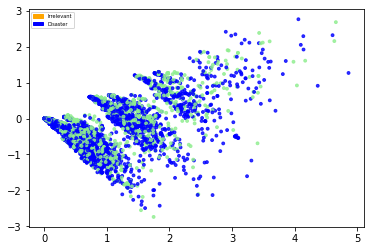

<Figure size 3600x3600 with 0 Axes>

In [8]:
color_mapper = {label:idx for idx,label in enumerate(set(y_train))}
color_column = [color_mapper[label] for label in y_train]
colors = ['blue','lightgreen']

plt.scatter(scores[:,0], scores[:,1], s=8, alpha=.8, c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='orange', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 5})


fig = plt.figure(figsize=(50, 50))          
plt.show()

In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(x_train_docMat, y_train) 
y_predicted_counts = clf.predict(X_test_docMan)

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_performance_metrics(y_test, y_predicted_counts):
    precision = precision_score(y_test, y_predicted_counts, pos_label=None, average='weighted')             
    recall = recall_score(y_test, y_predicted_counts, pos_label=None, average='weighted')
    f1 = f1_score(y_test, y_predicted_counts, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted_counts)
    return (accuracy, precision, recall, f1)

accuracy, precision, recall, f1 = get_performance_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.771, precision = 0.770, recall = 0.771, f1 = 0.770


In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted_counts)


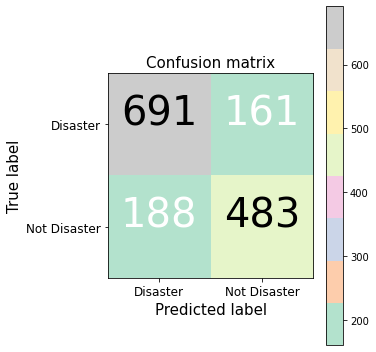

In [12]:
import itertools
title='Confusion matrix'
classes=['Disaster','Not Disaster']

def plot_confusion_matrix(cm, title, classes, cmap = 'Pastel2'):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap = 'Pastel2')
    plt.title(title, fontsize=15)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 12)
    plt.yticks(tick_marks, classes, fontsize = 12)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] < thresh else "black", fontsize=40)
        
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    
plot_confusion_matrix(cm, title, classes)

In [13]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(cv, clf, 10)

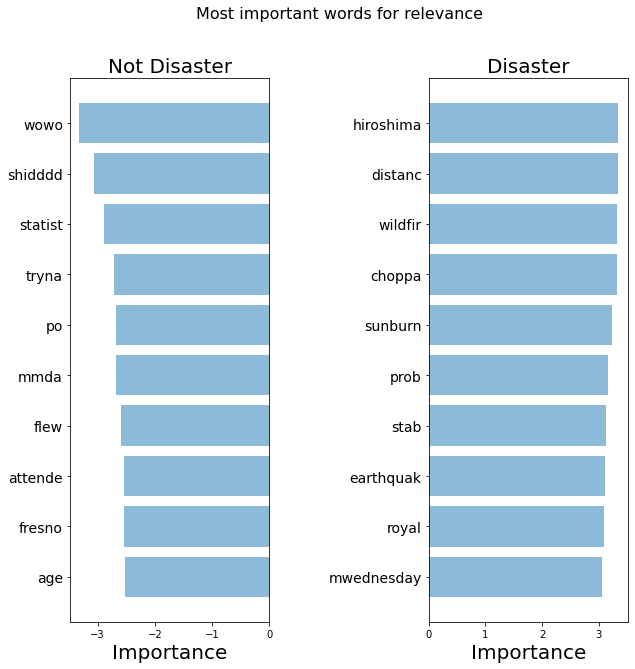

In [14]:

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Not Disaster', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")